In [1]:
# =============================================================================
# Cell 1: Imports and Setup
# =============================================================================
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.cuda.amp import GradScaler, autocast

# --- Import our custom modules ---
import sys
sys.path.append('../')
from src.data_loader import get_data_loaders
from src.models import UNet
from src.loss import DiceLoss, FocalLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3  # Increased from 1e-4
BATCH_SIZE = 16  # Increased from 8 (adjust based on your GPU memory)
IMAGE_SIZE = (256, 256)
NUM_EPOCHS = 50  # Increased epochs
NUM_WORKERS = 4  # Increased workers
DATA_PATH = '../data/CASIA2'
WEIGHT_DECAY = 1e-5  # Add L2 regularization

print(f"Using device: {DEVICE}")
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.benchmark = True  # Speed up training

Using device: cuda


In [2]:
# =============================================================================
# Cell 2: Load Data
# =============================================================================

train_loader, val_loader, test_loader = get_data_loaders(
    root_dir=DATA_PATH,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    num_workers=NUM_WORKERS
)

print(f"\nData loaded successfully.")
print(f"{len(train_loader)} batches in the training loader.")
print(f"{len(val_loader)} batches in the validation loader.")

Found 4981 matching image-mask pairs.
Found 4981 matching image-mask pairs.
Found 4981 matching image-mask pairs.

Dataset Split:
  Training set size: 3586
  Validation set size: 897
  Test set size: 498
  Total: 4981

Data loaded successfully.
224 batches in the training loader.
57 batches in the validation loader.


In [3]:
# =============================================================================
# Cell 3: Initialize Model, Loss, and Optimizer
# =============================================================================

model = UNet(n_channels=4, n_classes=1, dropout=0.1).to(DEVICE)

# Loss Function with weighted combination
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()
focal_loss = FocalLoss()

# Use AdamW instead of Adam (better weight decay handling)
optimizer = AdamW(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Better Learning Rate Scheduler - reduces LR when validation loss plateaus
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,  # Reduce by 50% (less aggressive)
    patience=5,  # Wait 5 epochs before reducing
    verbose=True,
    min_lr=1e-7
)

# Alternative: Cosine Annealing with Warm Restarts
# scheduler = CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=10,  # Restart every 10 epochs
#     T_mult=2,
#     eta_min=1e-6
# )

c:\Users\malek\anaconda3\envs\forgery_gpu\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [4]:
# =============================================================================
# Cell 4: Improved Training Loop with Mixed Precision
# =============================================================================

# Mixed precision training for faster computation
scaler = GradScaler() if DEVICE == "cuda" else None

# Lists to store metrics
train_losses = []
val_losses = []
learning_rates = []
best_val_loss = float('inf')

# Early stopping parameters
patience_counter = 0
early_stop_patience = 15

print("Starting training...")

for epoch in range(NUM_EPOCHS):
    model.train()
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    epoch_train_loss = 0.0
    epoch_bce_loss = 0.0
    epoch_dice_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)
        
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with torch.autocast(device_type=DEVICE):
                predictions = model(data)
                
                # Weighted loss combination (tune these weights)
                loss_b = bce_loss(predictions, targets)
                loss_d = dice_loss(predictions, targets)
                loss_f = focal_loss(predictions, targets)
                loss = 0.4 * loss_b + 0.4 * loss_d + 0.2 * loss_f  # Equal weighting
            
            scaler.scale(loss).backward()
            
            # Gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
        else:
            predictions = model(data)
            loss_b = bce_loss(predictions, targets)
            loss_d = dice_loss(predictions, targets)
            loss = 0.5 * loss_b + 0.5 * loss_d
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        epoch_train_loss += loss.item()
        epoch_bce_loss += loss_b.item()
        epoch_dice_loss += loss_d.item()
        
        loop.set_postfix(
            loss=loss.item(),
            bce=loss_b.item(),
            dice=loss_d.item(),
            lr=optimizer.param_groups[0]['lr']
        )

    # --- Validation Phase ---
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_bce = 0.0
    epoch_val_dice = 0.0
    
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=DEVICE)
            targets = targets.to(device=DEVICE)
            
            if scaler is not None:
                with torch.autocast(device_type=DEVICE):
                    predictions = model(data)
                    val_loss_b = bce_loss(predictions, targets)
                    val_loss_d = dice_loss(predictions, targets)
                    val_loss = 0.5 * val_loss_b + 0.5 * val_loss_d
            else:
                predictions = model(data)
                val_loss_b = bce_loss(predictions, targets)
                val_loss_d = dice_loss(predictions, targets)
                val_loss = 0.5 * val_loss_b + 0.5 * val_loss_d
            
            epoch_val_loss += val_loss.item()
            epoch_val_bce += val_loss_b.item()
            epoch_val_dice += val_loss_d.item()
    
    # Calculate average losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_train_bce = epoch_bce_loss / len(train_loader)
    avg_train_dice = epoch_dice_loss / len(train_loader)
    avg_val_bce = epoch_val_bce / len(val_loader)
    avg_val_dice = epoch_val_dice / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train -> Loss: {avg_train_loss:.4f}, BCE: {avg_train_bce:.4f}, Dice: {avg_train_dice:.4f}")
    print(f"Val   -> Loss: {avg_val_loss:.4f}, BCE: {avg_val_bce:.4f}, Dice: {avg_val_dice:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Learning rate scheduling
    scheduler.step(avg_val_loss)  # For ReduceLROnPlateau
    # scheduler.step()  # For CosineAnnealingWarmRestarts
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
        }, 'best_model.pth')
        print(f"✓ Best model saved! Val Loss: {best_val_loss:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\nTraining finished!")

C:\Users\malek\AppData\Local\Temp\ipykernel_11652\376058438.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if DEVICE == "cuda" else None


Starting training...


Epoch 1/50: 100%|██████████| 224/224 [00:46<00:00,  4.79it/s, bce=0.381, dice=0.866, loss=0.509, lr=0.001]



Epoch 1/50
Train -> Loss: 0.4873, BCE: 0.3441, Dice: 0.8574
Val   -> Loss: 0.5821, BCE: 0.3484, Dice: 0.8157
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5821


Epoch 2/50: 100%|██████████| 224/224 [00:33<00:00,  6.60it/s, bce=0.304, dice=0.813, loss=0.453, lr=0.001]



Epoch 2/50
Train -> Loss: 0.4774, BCE: 0.3215, Dice: 0.8537
Val   -> Loss: 0.5740, BCE: 0.3209, Dice: 0.8272
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5740


Epoch 3/50: 100%|██████████| 224/224 [00:34<00:00,  6.59it/s, bce=0.313, dice=0.887, loss=0.487, lr=0.001]



Epoch 3/50
Train -> Loss: 0.4751, BCE: 0.3205, Dice: 0.8488
Val   -> Loss: 0.5693, BCE: 0.3187, Dice: 0.8199
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5693


Epoch 4/50: 100%|██████████| 224/224 [00:32<00:00,  6.84it/s, bce=0.344, dice=0.914, loss=0.512, lr=0.001]



Epoch 4/50
Train -> Loss: 0.4736, BCE: 0.3198, Dice: 0.8459
Val   -> Loss: 0.5662, BCE: 0.3197, Dice: 0.8126
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5662


Epoch 5/50: 100%|██████████| 224/224 [00:33<00:00,  6.68it/s, bce=0.289, dice=0.793, loss=0.439, lr=0.001]



Epoch 5/50
Train -> Loss: 0.4748, BCE: 0.3192, Dice: 0.8497
Val   -> Loss: 0.5640, BCE: 0.3135, Dice: 0.8145
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5640


Epoch 6/50: 100%|██████████| 224/224 [00:33<00:00,  6.59it/s, bce=0.343, dice=0.782, loss=0.459, lr=0.001]



Epoch 6/50
Train -> Loss: 0.4720, BCE: 0.3182, Dice: 0.8432
Val   -> Loss: 0.5696, BCE: 0.3329, Dice: 0.8063
Learning Rate: 1.00e-03


Epoch 7/50: 100%|██████████| 224/224 [00:33<00:00,  6.74it/s, bce=0.386, dice=0.844, loss=0.502, lr=0.001]



Epoch 7/50
Train -> Loss: 0.4729, BCE: 0.3188, Dice: 0.8451
Val   -> Loss: 0.5621, BCE: 0.3139, Dice: 0.8102
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5621


Epoch 8/50: 100%|██████████| 224/224 [00:33<00:00,  6.68it/s, bce=0.38, dice=0.794, loss=0.48, lr=0.001]  



Epoch 8/50
Train -> Loss: 0.4728, BCE: 0.3195, Dice: 0.8438
Val   -> Loss: 0.5741, BCE: 0.3392, Dice: 0.8091
Learning Rate: 1.00e-03


Epoch 9/50: 100%|██████████| 224/224 [00:34<00:00,  6.53it/s, bce=0.312, dice=0.84, loss=0.467, lr=0.001] 



Epoch 9/50
Train -> Loss: 0.4739, BCE: 0.3183, Dice: 0.8484
Val   -> Loss: 0.5687, BCE: 0.3311, Dice: 0.8062
Learning Rate: 1.00e-03


Epoch 10/50: 100%|██████████| 224/224 [00:32<00:00,  6.86it/s, bce=0.277, dice=0.905, loss=0.478, lr=0.001]



Epoch 10/50
Train -> Loss: 0.4707, BCE: 0.3190, Dice: 0.8387
Val   -> Loss: 0.5603, BCE: 0.3180, Dice: 0.8027
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5603


Epoch 11/50: 100%|██████████| 224/224 [00:33<00:00,  6.76it/s, bce=0.225, dice=0.824, loss=0.424, lr=0.001]



Epoch 11/50
Train -> Loss: 0.4725, BCE: 0.3193, Dice: 0.8438
Val   -> Loss: 0.5703, BCE: 0.3273, Dice: 0.8133
Learning Rate: 1.00e-03


Epoch 12/50: 100%|██████████| 224/224 [00:33<00:00,  6.69it/s, bce=0.286, dice=0.792, loss=0.437, lr=0.001]



Epoch 12/50
Train -> Loss: 0.4712, BCE: 0.3174, Dice: 0.8419
Val   -> Loss: 0.5648, BCE: 0.3284, Dice: 0.8013
Learning Rate: 1.00e-03


Epoch 13/50: 100%|██████████| 224/224 [00:33<00:00,  6.64it/s, bce=0.3, dice=0.732, loss=0.419, lr=0.001]  



Epoch 13/50
Train -> Loss: 0.4712, BCE: 0.3182, Dice: 0.8409
Val   -> Loss: 0.5591, BCE: 0.3211, Dice: 0.7971
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5591


Epoch 14/50: 100%|██████████| 224/224 [00:35<00:00,  6.38it/s, bce=0.343, dice=0.886, loss=0.5, lr=0.001]  



Epoch 14/50
Train -> Loss: 0.4721, BCE: 0.3194, Dice: 0.8420
Val   -> Loss: 0.5576, BCE: 0.3180, Dice: 0.7971
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5576


Epoch 15/50: 100%|██████████| 224/224 [00:35<00:00,  6.25it/s, bce=0.344, dice=0.759, loss=0.449, lr=0.001]



Epoch 15/50
Train -> Loss: 0.4711, BCE: 0.3174, Dice: 0.8416
Val   -> Loss: 0.5589, BCE: 0.3092, Dice: 0.8085
Learning Rate: 1.00e-03


Epoch 16/50: 100%|██████████| 224/224 [00:33<00:00,  6.68it/s, bce=0.359, dice=0.912, loss=0.518, lr=0.001]



Epoch 16/50
Train -> Loss: 0.4708, BCE: 0.3180, Dice: 0.8403
Val   -> Loss: 0.5559, BCE: 0.3167, Dice: 0.7951
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5559


Epoch 17/50: 100%|██████████| 224/224 [00:33<00:00,  6.76it/s, bce=0.225, dice=0.907, loss=0.457, lr=0.001]



Epoch 17/50
Train -> Loss: 0.4700, BCE: 0.3168, Dice: 0.8396
Val   -> Loss: 0.5584, BCE: 0.3243, Dice: 0.7926
Learning Rate: 1.00e-03


Epoch 18/50: 100%|██████████| 224/224 [00:34<00:00,  6.54it/s, bce=0.276, dice=0.882, loss=0.468, lr=0.001]



Epoch 18/50
Train -> Loss: 0.4721, BCE: 0.3198, Dice: 0.8417
Val   -> Loss: 0.5607, BCE: 0.3235, Dice: 0.7980
Learning Rate: 1.00e-03


Epoch 19/50: 100%|██████████| 224/224 [00:33<00:00,  6.76it/s, bce=0.206, dice=0.948, loss=0.465, lr=0.001]



Epoch 19/50
Train -> Loss: 0.4723, BCE: 0.3187, Dice: 0.8437
Val   -> Loss: 0.5610, BCE: 0.3153, Dice: 0.8067
Learning Rate: 1.00e-03


Epoch 20/50: 100%|██████████| 224/224 [00:32<00:00,  6.97it/s, bce=0.229, dice=0.775, loss=0.405, lr=0.001]



Epoch 20/50
Train -> Loss: 0.4690, BCE: 0.3170, Dice: 0.8363
Val   -> Loss: 0.5561, BCE: 0.3255, Dice: 0.7867
Learning Rate: 1.00e-03


Epoch 21/50: 100%|██████████| 224/224 [00:32<00:00,  6.90it/s, bce=0.325, dice=0.852, loss=0.478, lr=0.001]



Epoch 21/50
Train -> Loss: 0.4691, BCE: 0.3172, Dice: 0.8368
Val   -> Loss: 0.5540, BCE: 0.3091, Dice: 0.7988
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5540


Epoch 22/50: 100%|██████████| 224/224 [00:31<00:00,  7.13it/s, bce=0.358, dice=0.679, loss=0.425, lr=0.001]



Epoch 22/50
Train -> Loss: 0.4702, BCE: 0.3173, Dice: 0.8399
Val   -> Loss: 0.5601, BCE: 0.3205, Dice: 0.7997
Learning Rate: 1.00e-03


Epoch 23/50: 100%|██████████| 224/224 [00:32<00:00,  6.97it/s, bce=0.312, dice=0.811, loss=0.456, lr=0.001]



Epoch 23/50
Train -> Loss: 0.4709, BCE: 0.3172, Dice: 0.8414
Val   -> Loss: 0.5555, BCE: 0.3141, Dice: 0.7968
Learning Rate: 1.00e-03


Epoch 24/50: 100%|██████████| 224/224 [00:32<00:00,  6.80it/s, bce=0.318, dice=0.9, loss=0.495, lr=0.001]  



Epoch 24/50
Train -> Loss: 0.4706, BCE: 0.3188, Dice: 0.8390
Val   -> Loss: 0.5562, BCE: 0.3145, Dice: 0.7978
Learning Rate: 1.00e-03


Epoch 25/50: 100%|██████████| 224/224 [00:32<00:00,  6.91it/s, bce=0.239, dice=0.839, loss=0.435, lr=0.001]



Epoch 25/50
Train -> Loss: 0.4692, BCE: 0.3158, Dice: 0.8386
Val   -> Loss: 0.5594, BCE: 0.3182, Dice: 0.8006
Learning Rate: 1.00e-03


Epoch 26/50: 100%|██████████| 224/224 [00:32<00:00,  6.99it/s, bce=0.258, dice=0.933, loss=0.482, lr=0.001]



Epoch 26/50
Train -> Loss: 0.4686, BCE: 0.3159, Dice: 0.8371
Val   -> Loss: 0.5588, BCE: 0.3175, Dice: 0.8001
Learning Rate: 1.00e-03


Epoch 27/50: 100%|██████████| 224/224 [00:32<00:00,  6.90it/s, bce=0.226, dice=0.841, loss=0.43, lr=0.001] 



Epoch 27/50
Train -> Loss: 0.4677, BCE: 0.3148, Dice: 0.8354
Val   -> Loss: 0.5537, BCE: 0.3113, Dice: 0.7960
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5537


Epoch 28/50: 100%|██████████| 224/224 [00:33<00:00,  6.77it/s, bce=0.357, dice=0.684, loss=0.426, lr=0.001]



Epoch 28/50
Train -> Loss: 0.4677, BCE: 0.3150, Dice: 0.8356
Val   -> Loss: 0.5621, BCE: 0.3183, Dice: 0.8059
Learning Rate: 1.00e-03


Epoch 29/50: 100%|██████████| 224/224 [00:32<00:00,  6.88it/s, bce=0.274, dice=0.941, loss=0.491, lr=0.001]



Epoch 29/50
Train -> Loss: 0.4709, BCE: 0.3177, Dice: 0.8405
Val   -> Loss: 0.5633, BCE: 0.3253, Dice: 0.8013
Learning Rate: 1.00e-03


Epoch 30/50: 100%|██████████| 224/224 [00:32<00:00,  6.97it/s, bce=0.341, dice=0.91, loss=0.508, lr=0.001] 



Epoch 30/50
Train -> Loss: 0.4681, BCE: 0.3155, Dice: 0.8366
Val   -> Loss: 0.5521, BCE: 0.3081, Dice: 0.7960
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5521


Epoch 31/50: 100%|██████████| 224/224 [00:33<00:00,  6.69it/s, bce=0.296, dice=0.864, loss=0.472, lr=0.001]



Epoch 31/50
Train -> Loss: 0.4689, BCE: 0.3180, Dice: 0.8357
Val   -> Loss: 0.5540, BCE: 0.3136, Dice: 0.7944
Learning Rate: 1.00e-03


Epoch 32/50: 100%|██████████| 224/224 [00:32<00:00,  6.79it/s, bce=0.402, dice=0.803, loss=0.494, lr=0.001]



Epoch 32/50
Train -> Loss: 0.4678, BCE: 0.3162, Dice: 0.8338
Val   -> Loss: 0.5571, BCE: 0.3100, Dice: 0.8041
Learning Rate: 1.00e-03


Epoch 33/50: 100%|██████████| 224/224 [00:38<00:00,  5.86it/s, bce=0.277, dice=0.904, loss=0.478, lr=0.001]



Epoch 33/50
Train -> Loss: 0.4685, BCE: 0.3152, Dice: 0.8372
Val   -> Loss: 0.5611, BCE: 0.3302, Dice: 0.7920
Learning Rate: 1.00e-03


Epoch 34/50: 100%|██████████| 224/224 [00:38<00:00,  5.86it/s, bce=0.266, dice=0.843, loss=0.449, lr=0.001]



Epoch 34/50
Train -> Loss: 0.4690, BCE: 0.3165, Dice: 0.8370
Val   -> Loss: 0.5568, BCE: 0.3117, Dice: 0.8019
Learning Rate: 1.00e-03


Epoch 35/50: 100%|██████████| 224/224 [00:34<00:00,  6.56it/s, bce=0.347, dice=0.805, loss=0.469, lr=0.001]



Epoch 35/50
Train -> Loss: 0.4698, BCE: 0.3164, Dice: 0.8393
Val   -> Loss: 0.5574, BCE: 0.3129, Dice: 0.8019
Learning Rate: 1.00e-03


Epoch 36/50: 100%|██████████| 224/224 [00:32<00:00,  6.91it/s, bce=0.267, dice=0.852, loss=0.452, lr=0.001]



Epoch 36/50
Train -> Loss: 0.4693, BCE: 0.3153, Dice: 0.8395
Val   -> Loss: 0.5553, BCE: 0.3142, Dice: 0.7963
Learning Rate: 1.00e-03


Epoch 37/50: 100%|██████████| 224/224 [00:32<00:00,  6.93it/s, bce=0.327, dice=0.88, loss=0.491, lr=0.0005] 



Epoch 37/50
Train -> Loss: 0.4684, BCE: 0.3158, Dice: 0.8364
Val   -> Loss: 0.5527, BCE: 0.3120, Dice: 0.7934
Learning Rate: 5.00e-04


Epoch 38/50: 100%|██████████| 224/224 [00:33<00:00,  6.74it/s, bce=0.34, dice=0.855, loss=0.487, lr=0.0005] 



Epoch 38/50
Train -> Loss: 0.4659, BCE: 0.3139, Dice: 0.8319
Val   -> Loss: 0.5551, BCE: 0.3172, Dice: 0.7931
Learning Rate: 5.00e-04


Epoch 39/50: 100%|██████████| 224/224 [00:32<00:00,  6.95it/s, bce=0.383, dice=0.766, loss=0.47, lr=0.0005] 



Epoch 39/50
Train -> Loss: 0.4682, BCE: 0.3148, Dice: 0.8372
Val   -> Loss: 0.5523, BCE: 0.3129, Dice: 0.7918
Learning Rate: 5.00e-04


Epoch 40/50: 100%|██████████| 224/224 [00:32<00:00,  6.94it/s, bce=0.357, dice=0.849, loss=0.492, lr=0.0005]



Epoch 40/50
Train -> Loss: 0.4662, BCE: 0.3148, Dice: 0.8318
Val   -> Loss: 0.5529, BCE: 0.3059, Dice: 0.7998
Learning Rate: 5.00e-04


Epoch 41/50: 100%|██████████| 224/224 [00:32<00:00,  6.83it/s, bce=0.332, dice=0.924, loss=0.511, lr=0.0005]



Epoch 41/50
Train -> Loss: 0.4670, BCE: 0.3148, Dice: 0.8339
Val   -> Loss: 0.5537, BCE: 0.3139, Dice: 0.7935
Learning Rate: 5.00e-04


Epoch 42/50: 100%|██████████| 224/224 [00:32<00:00,  6.83it/s, bce=0.319, dice=0.892, loss=0.492, lr=0.0005]



Epoch 42/50
Train -> Loss: 0.4658, BCE: 0.3134, Dice: 0.8321
Val   -> Loss: 0.5527, BCE: 0.3157, Dice: 0.7897
Learning Rate: 5.00e-04


Epoch 43/50: 100%|██████████| 224/224 [00:33<00:00,  6.77it/s, bce=0.291, dice=0.872, loss=0.472, lr=0.00025]



Epoch 43/50
Train -> Loss: 0.4659, BCE: 0.3134, Dice: 0.8323
Val   -> Loss: 0.5510, BCE: 0.3134, Dice: 0.7886
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5510


Epoch 44/50: 100%|██████████| 224/224 [00:34<00:00,  6.54it/s, bce=0.283, dice=0.92, loss=0.488, lr=0.00025] 



Epoch 44/50
Train -> Loss: 0.4671, BCE: 0.3149, Dice: 0.8342
Val   -> Loss: 0.5492, BCE: 0.3134, Dice: 0.7849
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5492


Epoch 45/50: 100%|██████████| 224/224 [00:35<00:00,  6.35it/s, bce=0.325, dice=0.876, loss=0.488, lr=0.00025]



Epoch 45/50
Train -> Loss: 0.4678, BCE: 0.3170, Dice: 0.8333
Val   -> Loss: 0.5506, BCE: 0.3138, Dice: 0.7874
Learning Rate: 2.50e-04


Epoch 46/50: 100%|██████████| 224/224 [00:30<00:00,  7.23it/s, bce=0.253, dice=0.834, loss=0.44, lr=0.00025] 



Epoch 46/50
Train -> Loss: 0.4632, BCE: 0.3130, Dice: 0.8264
Val   -> Loss: 0.5450, BCE: 0.3077, Dice: 0.7823
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5450


Epoch 47/50: 100%|██████████| 224/224 [00:31<00:00,  7.20it/s, bce=0.201, dice=0.829, loss=0.415, lr=0.00025]



Epoch 47/50
Train -> Loss: 0.4623, BCE: 0.3097, Dice: 0.8270
Val   -> Loss: 0.5453, BCE: 0.3082, Dice: 0.7825
Learning Rate: 2.50e-04


Epoch 48/50: 100%|██████████| 224/224 [00:31<00:00,  7.19it/s, bce=0.278, dice=0.671, loss=0.385, lr=0.00025]



Epoch 48/50
Train -> Loss: 0.4657, BCE: 0.3161, Dice: 0.8291
Val   -> Loss: 0.5446, BCE: 0.3028, Dice: 0.7865
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5446


Epoch 49/50: 100%|██████████| 224/224 [00:31<00:00,  7.22it/s, bce=0.309, dice=0.859, loss=0.475, lr=0.00025]



Epoch 49/50
Train -> Loss: 0.4627, BCE: 0.3135, Dice: 0.8246
Val   -> Loss: 0.5441, BCE: 0.3040, Dice: 0.7842
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5441


Epoch 50/50: 100%|██████████| 224/224 [00:30<00:00,  7.23it/s, bce=0.266, dice=0.912, loss=0.476, lr=0.00025]



Epoch 50/50
Train -> Loss: 0.4622, BCE: 0.3116, Dice: 0.8244
Val   -> Loss: 0.5403, BCE: 0.3019, Dice: 0.7787
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5403

Training finished!


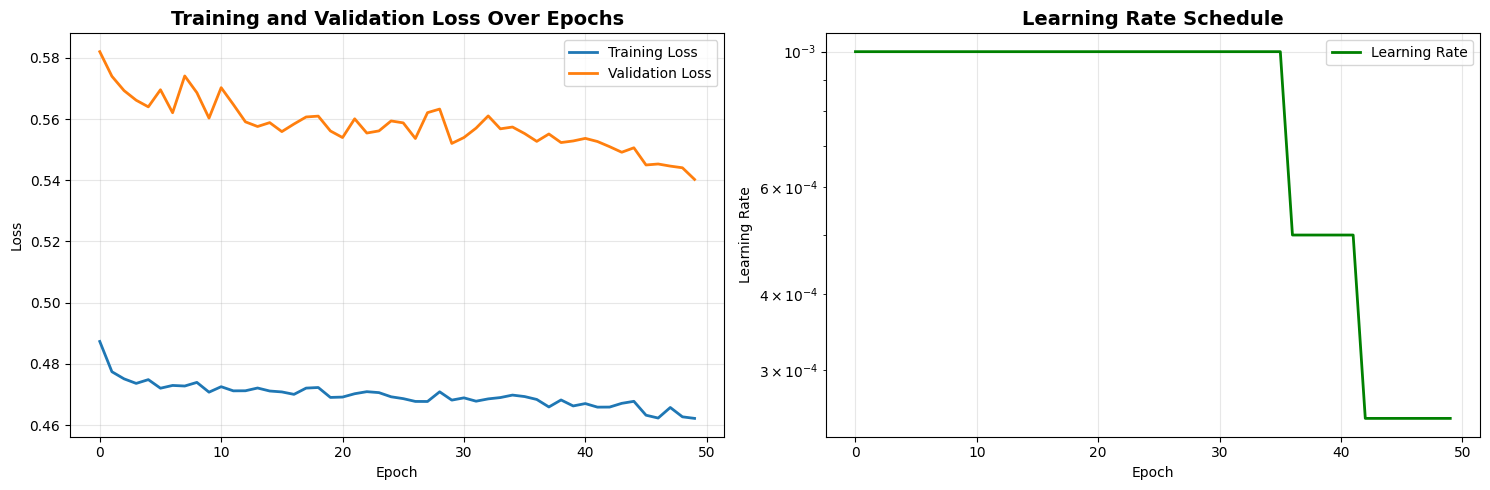

C:\Users\malek\AppData\Local\Temp\ipykernel_11652\1474569624.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
C:\Users\malek\Ap

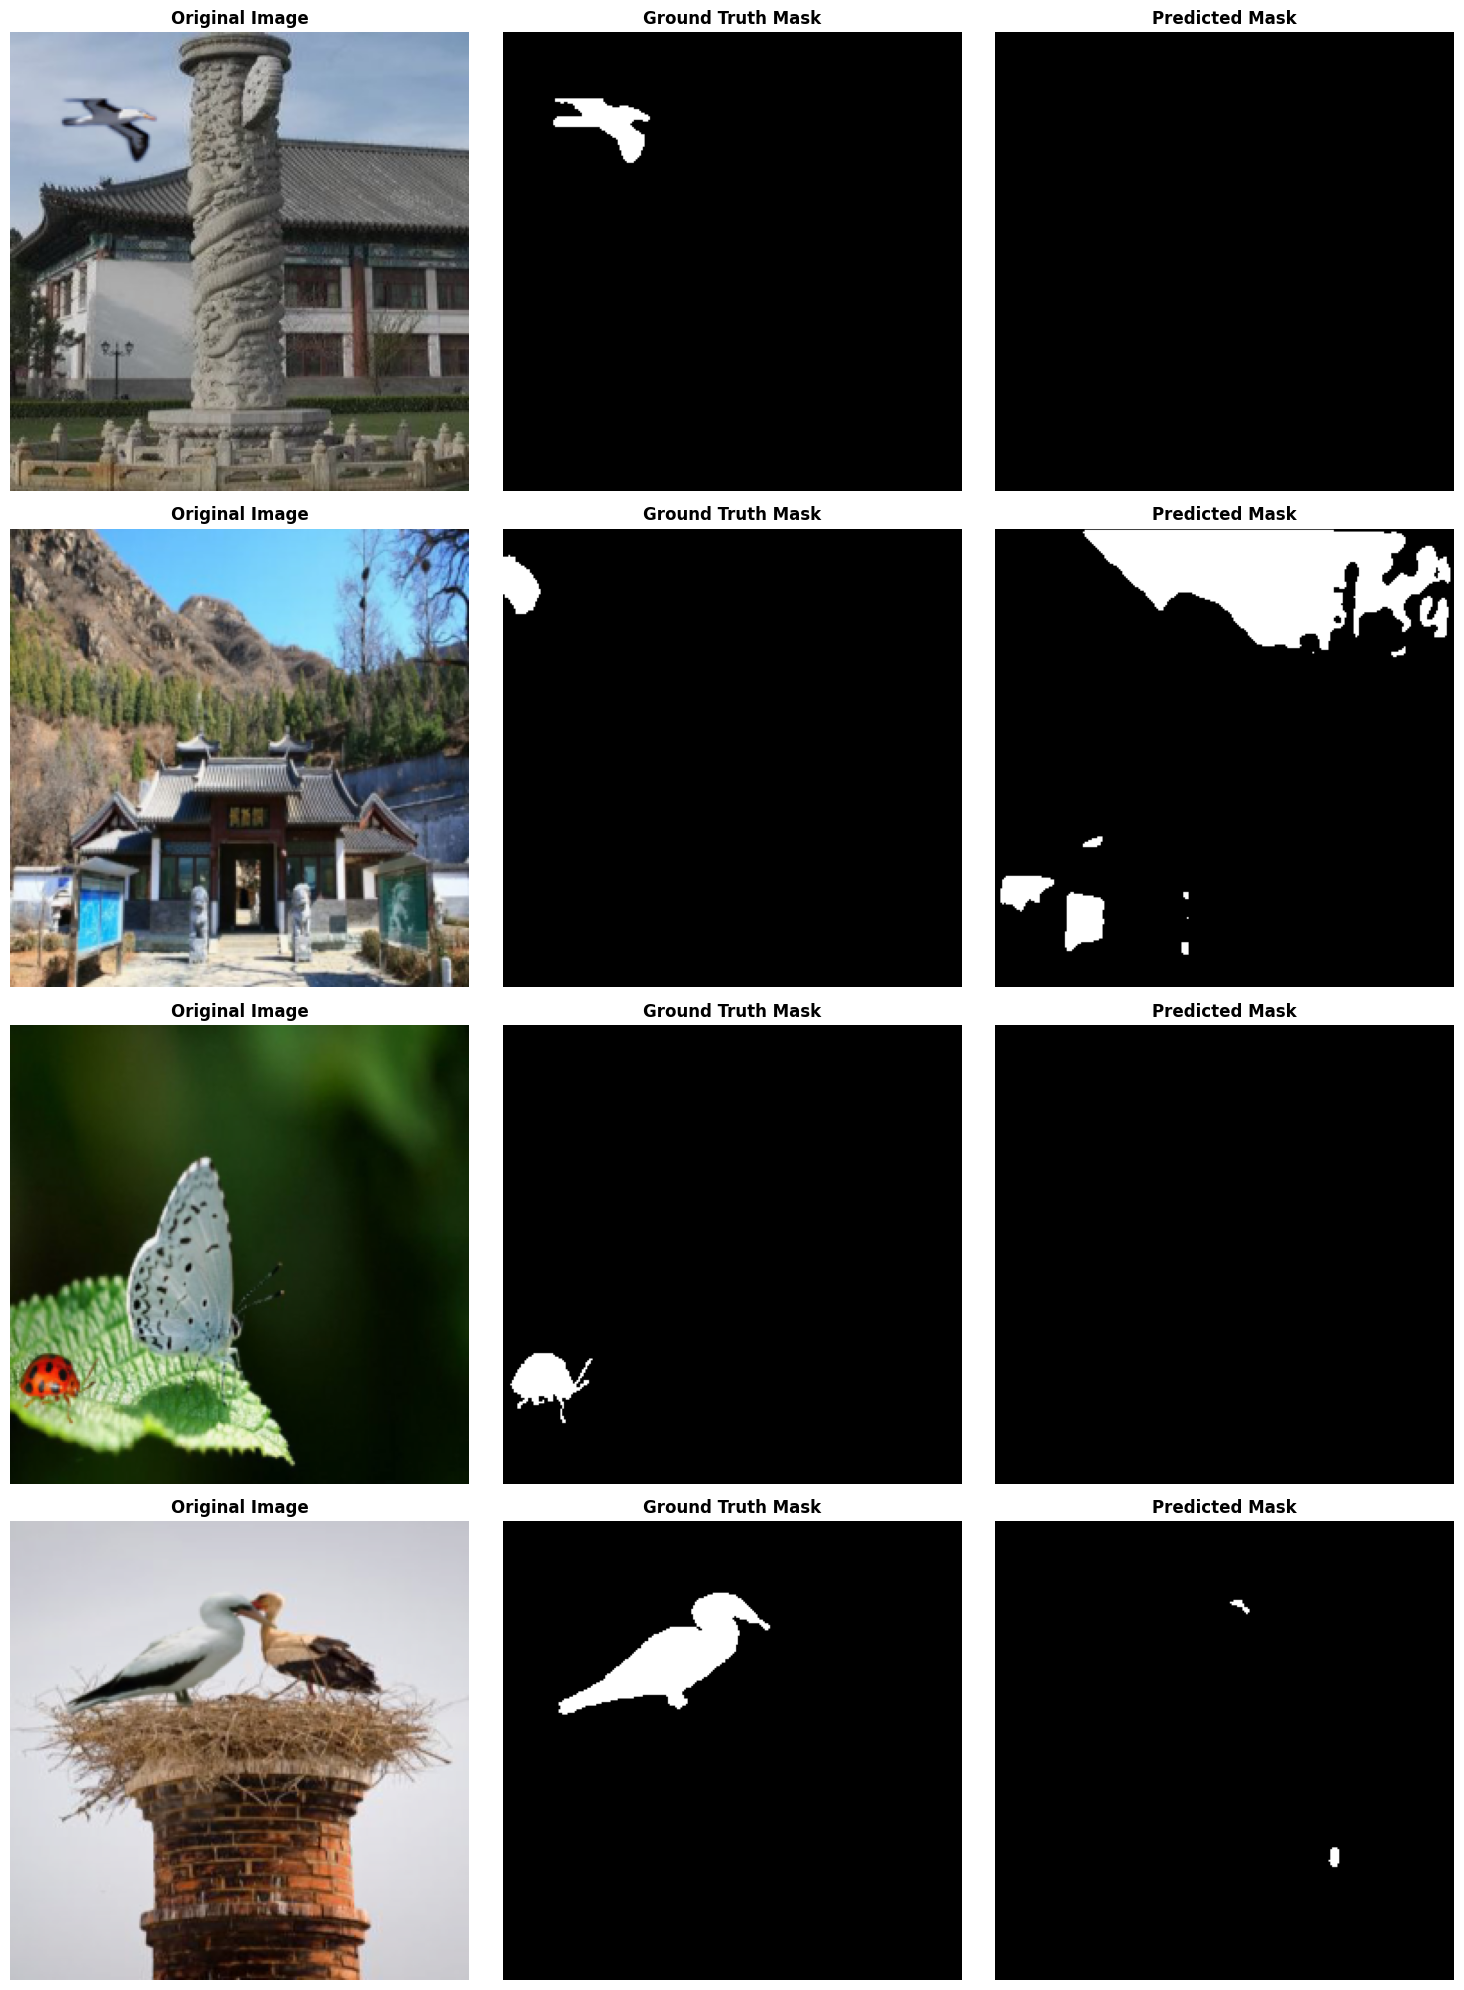

In [5]:
# =============================================================================
# Cell 5: Enhanced Visualization
# =============================================================================

# Plot training metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_title('Training and Validation Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate plot
axes[1].plot(learning_rates, label='Learning Rate', color='green', linewidth=2)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Load best model for visualization
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Visualize predictions
model.eval()
with torch.no_grad():
    data, targets = next(iter(val_loader))
    data = data.to(DEVICE)
    
    if scaler is not None:
        with torch.cuda.amp.autocast():
            preds = torch.sigmoid(model(data)).cpu()
    else:
        preds = torch.sigmoid(model(data)).cpu()
    
    num_images_to_show = min(4, len(data))
    
    fig, axes = plt.subplots(num_images_to_show, 3, figsize=(15, 5 * num_images_to_show))
    
    for i in range(num_images_to_show):
        # Get the 4-channel data for the i-th image
        image_with_ela = data[i]

        # Slice off the first 3 channels (RGB) for visualisation
        rgb_image_tensor = image_with_ela[:3, :, :]

        # Perform de-normalisation
        img = rgb_image_tensor.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        true_mask = targets[i].cpu().squeeze()
        pred_mask = (preds[i] > 0.5).float().squeeze()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image", fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask", fontweight='bold')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask", fontweight='bold')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()